Original code: 
https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613

In [1]:
# !pip uninstall torch torchvision torchaudio
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install matplotlib

In [4]:
import gc
import torch

# Clear CUDA cache function
def clear_cuda_cache():
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.reset_max_memory_cached()
    gc.collect()

clear_cuda_cache()

c:\Users\hp\Desktop\context_detector\env\lib\site-packages\torch\cuda\memory.py:330: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
c:\Users\hp\Desktop\context_detector\env\lib\site-packages\torch\cuda\memory.py:356: FutureWarning: torch.cuda.reset_max_memory_cached now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [5]:
import os
import pandas as pd 
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import nlpaug.augmenter.word as naw

# Check torch and CUDA versions
print(torch.__version__)  # Should display the version of PyTorch with CUDA support
print(torch.version.cuda)  # Should display the CUDA version
print(torch.backends.cudnn.version())  # Should display the cuDNN version
print(torch.cuda.is_available())  # Should return True if CUDA is available


# Set global variables and tokenizer parameters
SUBSAMPLE = False
SEED = 42
LR = 1e-5
PLOT_EDA = False
batch_size = 16
epochs = 5

tokenizer_params = {
    'add_special_tokens': True,     # adds [CLS] and [SEP] tags
    'return_attention_mask': True,  # useful for distinguishing between actual data and padding
    'pad_to_max_length': True,      # to ensure all sequences have the same length
    'truncation': True,
    'max_length': 128,  #256             # set the maximum length for sequences
    'return_tensors': 'pt'          # use 'pt' when using PyTorch, 'tf' for TensorFlow
}

# Load data 
print("Loading raw data...")
data = pd.read_csv('consumer_complaints.csv')
data = data[['product', 'consumer_complaint_narrative']]

### PREPROCESSING
# Drop rows with all columns missing and underrepresented categories
data = data.dropna()
categories_to_drop = ['Consumer Loan', 
                    'Bank account or service',
                    'Student loan', 
                    'Prepaid card',
                    'Payday loan', 
                    'Money transfers', 
                    'Other financial service']
data = data[~data['product'].isin(categories_to_drop)]

# Sub-sample to speed up the training process 
if SUBSAMPLE: 
    data = data.sample(frac=0.25, random_state=SEED)

if PLOT_EDA: 
    # EDA plots
    # 1. Create a histogram with the word count for the column 'consumer_complaint_narrative'
    data['narrative_word_count'] = data['consumer_complaint_narrative'].apply(lambda x: len(str(x).split()))

    plt.figure(figsize=(10, 6))
    plt.hist(data['narrative_word_count'], bins=30, edgecolor='k', alpha=0.7)
    plt.title('Histogram of Word Count in Consumer Complaint Narratives')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # 2. Create a barplot counting each unique value in the column 'issue'
    issue_counts = data['product'].value_counts()

    plt.figure(figsize=(12, 8))
    issue_counts.plot(kind='bar', color='skyblue', edgecolor='k', alpha=0.7)
    plt.title('Barplot of Issues in Consumer Complaints')
    plt.xlabel('Product')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.grid(axis='y', alpha=0.75)
    plt.show()


# Encoding labels
labels_ = data['product'].unique()
label_dict = {}
for idx, labels_ in enumerate(labels_):
    label_dict[labels_] = idx

# Encode product labels
data['label'] = data['product'].replace(label_dict)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    data.index.values,
    data['label'].values,
    test_size = 0.2,
    random_state=SEED,
    stratify = data['label'])

# Define data type in the original dataset
data['data_type'] = ['not_set'] * data.shape[0]
data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'

print('Loading tokenizer')
# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('bert-base-uncased',   # model name
                                          do_lower_case=True)    # convert to lowercase

print('format')
print(data[data.data_type=='train']['consumer_complaint_narrative'].values)

encoded_data_train = tokenizer.batch_encode_plus(
    data[data.data_type=='train']['consumer_complaint_narrative'].values,
    **tokenizer_params
)

encoded_data_val = tokenizer.batch_encode_plus(
    data[data.data_type=='val']['consumer_complaint_narrative'].values,
    **tokenizer_params
)

print('Extracting tokens...')
# Extract token input IDs and attention masks
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']

# Convert labels into tensors
labels_train = torch.tensor(data[data.data_type=='train']['label'].values)

# Repeat process for validation data
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type=='val']['label'].values)

# Create tensor 
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

print("Load model...")
# lOAD PRE-TRAINED MODEL 
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)


dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

# AdamW for Adam optimization with Weight decay
optimizer = AdamW(model.parameters(),
                  lr=LR,   
                  eps=1e-8)

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=100,
                                            num_training_steps=len(dataloader_train)*epochs)


c:\Users\hp\Desktop\context_detector\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Define accuracy functions
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def accuracy_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

In [ ]:
### CREATE BENCHMARK USING A ZERO-SHOT MODEL 
def evaluate(model, dataloader):
    model.eval()
    preds, true_vals = [], []
    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        preds.append(outputs.logits.detach().cpu().numpy())
        true_vals.append(inputs['labels'].detach().cpu().numpy())
    
    preds = np.concatenate(preds, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    return preds, true_vals

# Load the model and data on the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initial evaluation on validation set
initial_preds, initial_true_vals = evaluate(model, dataloader_validation)
initial_f1_score = f1_score_func(initial_preds, initial_true_vals)
print(f'F1 Score: {initial_f1_score}')
accuracy_per_class(initial_preds, initial_true_vals)


initial_preds, initial_true_vals = evaluate(model, dataloader_validation)
initial_accuracy = accuracy_func(initial_preds, initial_true_vals)
print(f'Initial Accuracy (Before Fine-tuning): {initial_accuracy}')

F1 Score: 0.12497114647304253
Class: Debt collection
Accuracy: 0/889

Class: Mortgage
Accuracy: 735/736

Class: Credit card
Accuracy: 3/402

Class: Credit reporting
Accuracy: 2/620

Initial Accuracy (Before Fine-tuning): 0.2795617680392898


Starting model training...


  0%|          | 0/5 [03:03<?, ?it/s]


Epoch 1
Training loss: 0.5199072419105554


 20%|██        | 1/5 [03:14<12:59, 194.95s/it]

Validation loss: 0.39405947710334693
F1 Score (Weighted): 0.8864404857768816
Accuracy: 0.8866641480921799


 20%|██        | 1/5 [06:17<12:59, 194.95s/it]


Epoch 2
Training loss: 0.2818589627398028


 40%|████      | 2/5 [06:29<09:44, 194.84s/it]

Validation loss: 0.4005648374329058
F1 Score (Weighted): 0.8963153687242554
Accuracy: 0.8968643747638836


 40%|████      | 2/5 [09:32<09:44, 194.84s/it]


Epoch 3
Training loss: 0.19576745001534115


 60%|██████    | 3/5 [09:44<06:29, 194.79s/it]

Validation loss: 0.42825636858349
F1 Score (Weighted): 0.8974206772945613
Accuracy: 0.8976199471099358


 60%|██████    | 3/5 [12:49<06:29, 194.79s/it]


Epoch 4
Training loss: 0.1246876636758795


 80%|████████  | 4/5 [13:00<03:15, 195.37s/it]

Validation loss: 0.5305367338409612
F1 Score (Weighted): 0.8978599563894261
Accuracy: 0.8979977332829618


 80%|████████  | 4/5 [15:59<03:15, 195.37s/it]


Epoch 5
Training loss: 0.08573310245239599


100%|██████████| 5/5 [16:11<00:00, 194.26s/it]


Validation loss: 0.5378467668552953
F1 Score (Weighted): 0.8963541599122408
Accuracy: 0.8964865885908576


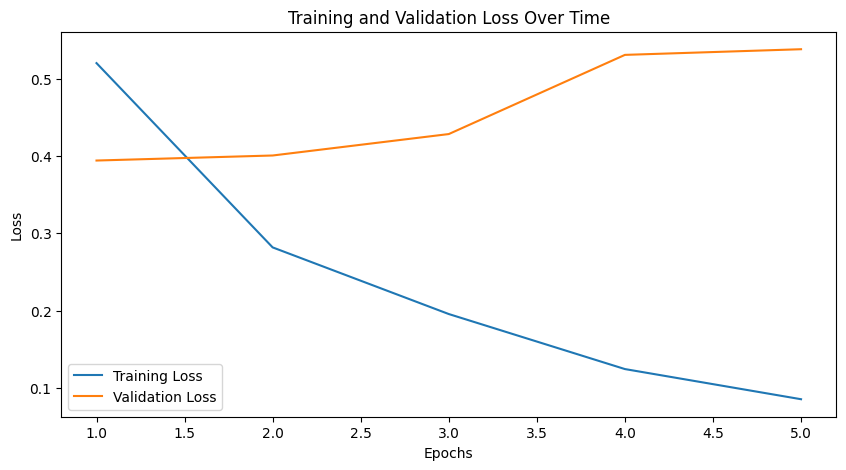

In [ ]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Starting model training...")
# Move model to device
model.to(device)

def accuracy_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }

        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

# Initialize lists to store losses for plotting
training_losses = []
validation_losses = []

# Ensure the directory for saving models exists
os.makedirs('models', exist_ok=True)

for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, ncols=100)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

    # Save the model at each epoch 
    torch.save(model.state_dict(), f'models/finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total / len(dataloader_train)
    training_losses.append(loss_train_avg)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    val_accuracy = accuracy_func(predictions, true_vals)
    validation_losses.append(val_loss)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Accuracy: {val_accuracy}')

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

Use the best model to compare how it classifies between classes compared to the original benchmark. 

In [ ]:
# Function to evaluate the model
def evaluate(model, dataloader):
    model.eval()
    preds, true_vals = [], []
    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        preds.append(outputs[1].detach().cpu().numpy())  # logits are at index 1
        true_vals.append(inputs['labels'].detach().cpu().numpy())
    
    preds = np.concatenate(preds, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    return preds, true_vals

# Function to print class-wise accuracy
# def accuracy_per_class(preds, labels, label_dict):
#     preds_flat = np.argmax(preds, axis=1).flatten()
#     labels_flat = labels.flatten()
#     label_dict_inverse = {v: k for k, v in label_dict.items()}

#     for label in np.unique(labels_flat):
#         y_preds = preds_flat[labels_flat == label]
#         y_true = labels_flat[labels_flat == label]
#         accuracy = len(y_preds[y_preds == label]) / len(y_true)
#         print(f'Class: {label_dict_inverse[label]}')
#         print(f'Accuracy: {len(y_preds[y_preds == label])}/{len(y_true)}\n')

# Load and evaluate the model from epoch 2
print("Loading model from epoch 2...")
model.load_state_dict(torch.load('models/finetuned_BERT_epoch_2.model'))
model.to(device)
preds_epoch_3, true_vals_epoch_3 = evaluate(model, dataloader_validation)
f1_score_epoch_3 = f1_score_func(preds_epoch_3, true_vals_epoch_3)
accuracy_epoch_3 = accuracy_func(preds_epoch_3, true_vals_epoch_3)

# Print F1 score and overall accuracy
print(f'F1 Score: {f1_score_epoch_3}')
print(f'Accuracy: {accuracy_epoch_3}')

# Print class-wise accuracy
accuracy_per_class(preds_epoch_3, true_vals_epoch_3, label_dict)


Loading model from epoch 2...
F1 Score: 0.8963153687242554
Accuracy: 0.8968643747638836
Class: Debt collection
Accuracy: 806/889

Class: Mortgage
Accuracy: 710/736

Class: Credit card
Accuracy: 349/402

Class: Credit reporting
Accuracy: 509/620



In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict))

model.to(device)

# Load best model and make prediction
model.load_state_dict(torch.load('models/finetuned_BERT_epoch_2.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['bert.encoder.layer.11.attention.self.query.weight', 'bert.encoder.layer.2.attention.self.key.bias', 'bert.encoder.layer.7.output.LayerNorm.weight', 'bert.encoder.layer.9.intermediate.dense.weight', 'bert.encoder.layer.11.attention.self.value.bias', 'bert.encoder.layer.8.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.8.output.dense.weight', 'bert.pooler.dense.weight', 'bert.encoder.layer.8.intermediate.dense.bias', 'bert.pooler.dense.bias', 'bert.encoder.layer.1.attention.self.query.bias', 'bert.encoder.layer.1.intermediate.dense.weight', 'bert.encoder.layer.8.attention.output.dense.bias', 'bert.encoder.layer.1.attention.self.value.weight', 'bert.encoder

RuntimeError: Error(s) in loading state_dict for DistilBertForSequenceClassification:
	Missing key(s) in state_dict: "distilbert.transformer.layer.6.attention.q_lin.weight", "distilbert.transformer.layer.6.attention.q_lin.bias", "distilbert.transformer.layer.6.attention.k_lin.weight", "distilbert.transformer.layer.6.attention.k_lin.bias", "distilbert.transformer.layer.6.attention.v_lin.weight", "distilbert.transformer.layer.6.attention.v_lin.bias", "distilbert.transformer.layer.6.attention.out_lin.weight", "distilbert.transformer.layer.6.attention.out_lin.bias", "distilbert.transformer.layer.6.sa_layer_norm.weight", "distilbert.transformer.layer.6.sa_layer_norm.bias", "distilbert.transformer.layer.6.ffn.lin1.weight", "distilbert.transformer.layer.6.ffn.lin1.bias", "distilbert.transformer.layer.6.ffn.lin2.weight", "distilbert.transformer.layer.6.ffn.lin2.bias", "distilbert.transformer.layer.6.output_layer_norm.weight", "distilbert.transformer.layer.6.output_layer_norm.bias", "distilbert.transformer.layer.7.attention.q_lin.weight", "distilbert.transformer.layer.7.attention.q_lin.bias", "distilbert.transformer.layer.7.attention.k_lin.weight", "distilbert.transformer.layer.7.attention.k_lin.bias", "distilbert.transformer.layer.7.attention.v_lin.weight", "distilbert.transformer.layer.7.attention.v_lin.bias", "distilbert.transformer.layer.7.attention.out_lin.weight", "distilbert.transformer.layer.7.attention.out_lin.bias", "distilbert.transformer.layer.7.sa_layer_norm.weight", "distilbert.transformer.layer.7.sa_layer_norm.bias", "distilbert.transformer.layer.7.ffn.lin1.weight", "distilbert.transformer.layer.7.ffn.lin1.bias", "distilbert.transformer.layer.7.ffn.lin2.weight", "distilbert.transformer.layer.7.ffn.lin2.bias", "distilbert.transformer.layer.7.output_layer_norm.weight", "distilbert.transformer.layer.7.output_layer_norm.bias", "distilbert.transformer.layer.8.attention.q_lin.weight", "distilbert.transformer.layer.8.attention.q_lin.bias", "distilbert.transformer.layer.8.attention.k_lin.weight", "distilbert.transformer.layer.8.attention.k_lin.bias", "distilbert.transformer.layer.8.attention.v_lin.weight", "distilbert.transformer.layer.8.attention.v_lin.bias", "distilbert.transformer.layer.8.attention.out_lin.weight", "distilbert.transformer.layer.8.attention.out_lin.bias", "distilbert.transformer.layer.8.sa_layer_norm.weight", "distilbert.transformer.layer.8.sa_layer_norm.bias", "distilbert.transformer.layer.8.ffn.lin1.weight", "distilbert.transformer.layer.8.ffn.lin1.bias", "distilbert.transformer.layer.8.ffn.lin2.weight", "distilbert.transformer.layer.8.ffn.lin2.bias", "distilbert.transformer.layer.8.output_layer_norm.weight", "distilbert.transformer.layer.8.output_layer_norm.bias", "distilbert.transformer.layer.9.attention.q_lin.weight", "distilbert.transformer.layer.9.attention.q_lin.bias", "distilbert.transformer.layer.9.attention.k_lin.weight", "distilbert.transformer.layer.9.attention.k_lin.bias", "distilbert.transformer.layer.9.attention.v_lin.weight", "distilbert.transformer.layer.9.attention.v_lin.bias", "distilbert.transformer.layer.9.attention.out_lin.weight", "distilbert.transformer.layer.9.attention.out_lin.bias", "distilbert.transformer.layer.9.sa_layer_norm.weight", "distilbert.transformer.layer.9.sa_layer_norm.bias", "distilbert.transformer.layer.9.ffn.lin1.weight", "distilbert.transformer.layer.9.ffn.lin1.bias", "distilbert.transformer.layer.9.ffn.lin2.weight", "distilbert.transformer.layer.9.ffn.lin2.bias", "distilbert.transformer.layer.9.output_layer_norm.weight", "distilbert.transformer.layer.9.output_layer_norm.bias", "distilbert.transformer.layer.10.attention.q_lin.weight", "distilbert.transformer.layer.10.attention.q_lin.bias", "distilbert.transformer.layer.10.attention.k_lin.weight", "distilbert.transformer.layer.10.attention.k_lin.bias", "distilbert.transformer.layer.10.attention.v_lin.weight", "distilbert.transformer.layer.10.attention.v_lin.bias", "distilbert.transformer.layer.10.attention.out_lin.weight", "distilbert.transformer.layer.10.attention.out_lin.bias", "distilbert.transformer.layer.10.sa_layer_norm.weight", "distilbert.transformer.layer.10.sa_layer_norm.bias", "distilbert.transformer.layer.10.ffn.lin1.weight", "distilbert.transformer.layer.10.ffn.lin1.bias", "distilbert.transformer.layer.10.ffn.lin2.weight", "distilbert.transformer.layer.10.ffn.lin2.bias", "distilbert.transformer.layer.10.output_layer_norm.weight", "distilbert.transformer.layer.10.output_layer_norm.bias", "distilbert.transformer.layer.11.attention.q_lin.weight", "distilbert.transformer.layer.11.attention.q_lin.bias", "distilbert.transformer.layer.11.attention.k_lin.weight", "distilbert.transformer.layer.11.attention.k_lin.bias", "distilbert.transformer.layer.11.attention.v_lin.weight", "distilbert.transformer.layer.11.attention.v_lin.bias", "distilbert.transformer.layer.11.attention.out_lin.weight", "distilbert.transformer.layer.11.attention.out_lin.bias", "distilbert.transformer.layer.11.sa_layer_norm.weight", "distilbert.transformer.layer.11.sa_layer_norm.bias", "distilbert.transformer.layer.11.ffn.lin1.weight", "distilbert.transformer.layer.11.ffn.lin1.bias", "distilbert.transformer.layer.11.ffn.lin2.weight", "distilbert.transformer.layer.11.ffn.lin2.bias", "distilbert.transformer.layer.11.output_layer_norm.weight", "distilbert.transformer.layer.11.output_layer_norm.bias". 

In [ ]:
# Check the model using one sample


# Fine-tunning with data augmentation 

Data augmentation techniques: 
1. Synonym replacement 
2. Random insertion 
3. Random swap 
4. Random deletion 
5. Back translation 
6. Noise injection 


Use data augmentation during model training. 

In [ ]:
# !pip install nlpaug
# !pip install nltk
# !python -m nltk.downloader all
# !pip install wordnet

In [ ]:
# import nlpaug.augmenter.word as naw
# import nltk

# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

# aug_syn = naw.SynonymAug(aug_src='wordnet')
# # aug_insert = naw.RandomWordAug(action="insert")
# aug_swap = naw.RandomWordAug(action="swap")
# aug_delete = naw.RandomWordAug(action="delete")
# augmenters = [aug_syn, aug_swap, aug_delete]

# # Apply data augmentation to data 
# def augment_text(text, augmenters, num_augmentations=1):
#     augmented_texts = [text]
#     for _ in range(num_augmentations):
#         augmenter = random.choice(augmenters)
#         augmented_text = augmenter.augment(text)
#         augmented_texts.append(augmented_text)
#     return augmented_texts


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# augmented_data = []
# for index, row in data.iterrows():
#     text = row['consumer_complaint_narrative']
#     augmented_texts = augment_text(text, augmenters, num_augmentations=2)
#     for augmented_text in augmented_texts:
#         augmented_data.append((augmented_text, row['label']))

# # Create new dataframe with augmented data and combine it with original dataset
# augmented_df = pd.DataFrame(augmented_data, columns=['consumer_complaint_narrative', 'label'])
# data = pd.concat([data, augmented_df], ignore_index=True)

# # Continue with tokenization and creating DataLoader as before
# encoded_data_train = tokenizer.batch_encode_plus(
#     data[data.data_type=='train']['consumer_complaint_narrative'].values,
#     **tokenizer_params
# )

# encoded_data_val = tokenizer.batch_encode_plus(
#     data[data.data_type=='val']['consumer_complaint_narrative'].values,
#     **tokenizer_params
# )

# input_ids_train = encoded_data_train['input_ids']
# attention_masks_train = encoded_data_train['attention_mask']
# labels_train = torch.tensor(data[data.data_type=='train']['label'].values)

# input_ids_val = encoded_data_val['input_ids']
# attention_masks_val = encoded_data_val['attention_mask']
# labels_val = torch.tensor(data[data.data_type=='val']['label'].values)

# dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
# dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
# dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

c:\Users\hp\Desktop\context_detector\env\lib\site-packages\transformers\tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Starting model training...


  0%|          | 0/5 [04:45<?, ?it/s]


Epoch 1
Training loss: 0.15893469988218947


 20%|██        | 1/5 [05:07<20:31, 307.92s/it]

Validation loss: 0.5018551978493496
F1 Score (Weighted): 0.8845496386829244
Accuracy: 0.8843974310540235


 20%|██        | 1/5 [09:53<20:31, 307.92s/it]


Epoch 2
Training loss: 0.1529485837413953


 40%|████      | 2/5 [10:15<15:23, 307.99s/it]

Validation loss: 0.5018551978493496
F1 Score (Weighted): 0.8845496386829244
Accuracy: 0.8843974310540235


 40%|████      | 2/5 [14:59<15:23, 307.99s/it]


Epoch 3
Training loss: 0.154154187168379


 60%|██████    | 3/5 [15:21<10:13, 306.94s/it]

Validation loss: 0.5018551978493496
F1 Score (Weighted): 0.8845496386829244
Accuracy: 0.8843974310540235


 60%|██████    | 3/5 [20:03<10:13, 306.94s/it]


Epoch 4
Training loss: 0.15416813386794148


 80%|████████  | 4/5 [20:26<05:06, 306.01s/it]

Validation loss: 0.5018551978493496
F1 Score (Weighted): 0.8845496386829244
Accuracy: 0.8843974310540235


 80%|████████  | 4/5 [25:13<05:06, 306.01s/it]


Epoch 5
Training loss: 0.15728549454475527


100%|██████████| 5/5 [25:35<00:00, 307.18s/it]


Validation loss: 0.5018551978493496
F1 Score (Weighted): 0.8845496386829244
Accuracy: 0.8843974310540235


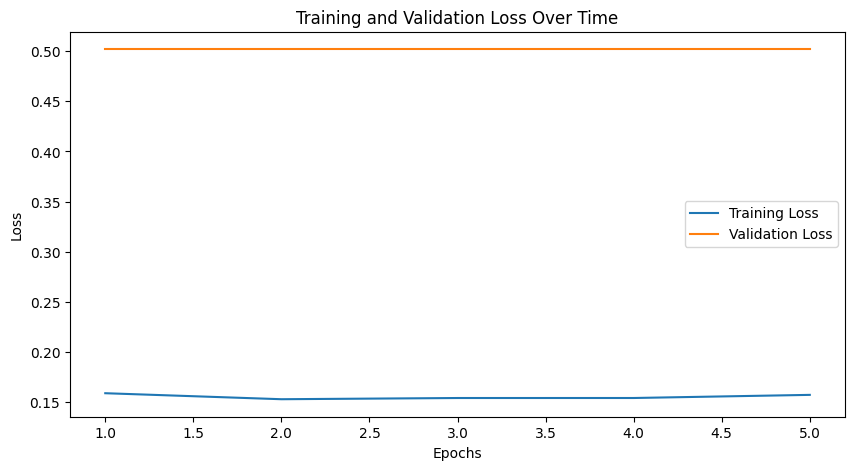

In [ ]:
# # Run model on augmented data 
# # Check for GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# print("Starting model training...")
# # Move model to device
# model.to(device)

# # Evaluation function
# def evaluate(dataloader_val):
#     model.eval()
#     loss_val_total = 0
#     predictions, true_vals = [], []

#     for batch in dataloader_val:
#         batch = tuple(b.to(device) for b in batch)
#         inputs = {
#             'input_ids': batch[0],
#             'attention_mask': batch[1],
#             'labels': batch[2],
#         }

#         with torch.no_grad():
#             outputs = model(**inputs)
#         loss = outputs[0]
#         logits = outputs[1]
#         loss_val_total += loss.item()
#         logits = logits.detach().cpu().numpy()
#         label_ids = inputs['labels'].cpu().numpy()
#         predictions.append(logits)
#         true_vals.append(label_ids)

#     loss_val_avg = loss_val_total / len(dataloader_val)
#     predictions = np.concatenate(predictions, axis=0)
#     true_vals = np.concatenate(true_vals, axis=0)

#     return loss_val_avg, predictions, true_vals

# # Initialize lists to store losses for plotting
# training_losses = []
# validation_losses = []

# # Training loop
# for epoch in tqdm(range(1, epochs + 1)):
#     model.train()
#     loss_train_total = 0
#     progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, ncols=100)
#     for batch in progress_bar:
#         model.zero_grad()
#         batch = tuple(b.to(device) for b in batch)
#         inputs = {
#             'input_ids': batch[0],
#             'attention_mask': batch[1],
#             'labels': batch[2],
#         }
#         outputs = model(**inputs)
#         loss = outputs[0]
#         loss_train_total += loss.item()
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         optimizer.step()
#         scheduler.step()
#         progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

#     # Save the model at each epoch 
#     torch.save(model.state_dict(), f'models/finetuned_BERT_epoch_aug_{epoch}.model')

#     tqdm.write(f'\nEpoch {epoch}')
#     loss_train_avg = loss_train_total / len(dataloader_train)
#     training_losses.append(loss_train_avg)
#     tqdm.write(f'Training loss: {loss_train_avg}')

#     val_loss, predictions, true_vals = evaluate(dataloader_validation)
#     val_f1 = f1_score_func(predictions, true_vals)
#     val_accuracy = accuracy_func(predictions, true_vals)
#     validation_losses.append(val_loss)
#     tqdm.write(f'Validation loss: {val_loss}')
#     tqdm.write(f'F1 Score (Weighted): {val_f1}')
#     tqdm.write(f'Accuracy: {val_accuracy}')

# # Plotting the training and validation losses
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, epochs + 1), training_losses, label='Training Loss')
# plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss Over Time')
# plt.legend()
# plt.show()


# Custom model
Resolve unbalancement using data augmentation on undersampled categories.

Change the code above including: 
- data augmentation for minority categories
- regularization to stabilize validation loss 


In [ ]:
# import os
# import pandas as pd
# import random
# import numpy as np
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import nlpaug.augmenter.word as naw
# from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from sklearn.metrics import f1_score, accuracy_score
# from sklearn.model_selection import train_test_split
# import torch

# # Check torch and CUDA versions
# print(torch.__version__)  # Should display the version of PyTorch with CUDA support
# print(torch.version.cuda)  # Should display the CUDA version
# print(torch.backends.cudnn.version())  # Should display the cuDNN version
# print(torch.cuda.is_available())  # Should return True if CUDA is available



# Set global variables and tokenizer parameters
SUBSAMPLE = False
DROPOUT_RATE = 0.5
WEIGHT_DECAY = 0.02
SEED = 42
LR = 2e-5
batch_size = 12
epochs = 3

tokenizer_params = {
    'add_special_tokens': True,     # adds [CLS] and [SEP] tags
    'return_attention_mask': True,  # useful for distinguishing between actual data and padding
    'pad_to_max_length': True,      # to ensure all sequences have the same length
    'truncation': True,
    'max_length': 256,              # set the maximum length for sequences
    'return_tensors': 'pt'          # use 'pt' when using PyTorch, 'tf' for TensorFlow
}

# Load data
print("Loading raw data...")
data = pd.read_csv('consumer_complaints.csv')
data = data[['product', 'consumer_complaint_narrative']]
data = data.dropna()
categories_to_drop = ['Consumer Loan', 'Student loan', 'Prepaid card', 'Payday loan', 'Money transfers', 'Other financial service']
data = data[~data['product'].isin(categories_to_drop)]

# Sub-sample to speed up the training process 
if SUBSAMPLE: 
    data = data.sample(frac=0.25, random_state=SEED)

# Example label dictionary for demonstration
label_dict = {label: idx for idx, label in enumerate(data['product'].unique())}

# Prepare data
data['label'] = data['product'].replace(label_dict)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    data.index.values,
    data['label'].values,
    test_size = 0.2,
    random_state=SEED,
    stratify = data['label'])

# Define data type in the original dataset
data['data_type'] = ['not_set'] * data.shape[0]
data.loc[X_train, 'data_type'] = 'train'
data.loc[X_val, 'data_type'] = 'val'

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

# Define augmenters
aug_syn = naw.SynonymAug(aug_src='wordnet')
aug_swap = naw.RandomWordAug(action="swap")
aug_delete = naw.RandomWordAug(action="delete")
augmenters = [aug_syn, aug_swap, aug_delete]

# Function to apply data augmentation to text
def augment_text(text, augmenters, num_augmentations=1):
    augmented_texts = [text]
    for _ in range(num_augmentations):
        augmenter = random.choice(augmenters)
        augmented_text = augmenter.augment(text)
        augmented_texts.append(augmented_text)
    return augmented_texts

# Check class distribution (we will use data augmentation to oversample underrepresented classes)
class_counts = data[data.data_type=='train']['product'].value_counts()

# Determine maximum class count 
max_count = class_counts.max()

# Augment minority classes to balance the dataset
augmented_data = []
for product, count in class_counts.items():
    if count < max_count:
        subset = data[(data['product'] == product) & (data['data_type'] == 'train')]
        needed_samples = max_count - count
        while needed_samples > 0:
            for index, row in subset.iterrows():
                if needed_samples <= 0:
                    break
                text = row['consumer_complaint_narrative']
                augmented_texts = augment_text(text, augmenters, num_augmentations=1)
                for augmented_text in augmented_texts:
                    augmented_data.append((augmented_text, row['label']))
                    needed_samples -= 1

# Create new dataframe with augmented data and combine it with the training dataset
augmented_df = pd.DataFrame(augmented_data, columns=['consumer_complaint_narrative', 'label'])
train_data = pd.concat([data[data.data_type=='train'][['consumer_complaint_narrative', 'label']], augmented_df], ignore_index=True)

# Ensure all entries are strings 
train_data['consumer_complaint_narrative'] = train_data['consumer_complaint_narrative'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# Continue with tokenization and creating DataLoader as before
encoded_data_train = tokenizer.batch_encode_plus(
    train_data['consumer_complaint_narrative'].values.tolist(),
    **tokenizer_params
)

encoded_data_val = tokenizer.batch_encode_plus(
    data[data.data_type=='val']['consumer_complaint_narrative'].values,
    **tokenizer_params
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_data['label'].values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data[data.data_type=='val']['label'].values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

# Load device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model with dropout
class DistilBertForSequenceClassificationWithDropout(torch.nn.Module):
    def __init__(self, model_name, num_labels, dropout_rate=0.3):
        super(DistilBertForSequenceClassificationWithDropout, self).__init__()
        self.distilbert = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.classifier = torch.nn.Linear(self.distilbert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        # Get the outputs from the DistilBERT model
        outputs = self.distilbert.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs[0]  # (batch_size, seq_len, hidden_size)

        # Apply dropout to the first token (CLS token) in the hidden state
        pooled_output = hidden_state[:, 0]  # (batch_size, hidden_size)
        pooled_output = self.dropout(pooled_output)

        # Pass the pooled output through the classifier layer
        logits = self.classifier(pooled_output)

        # Calculate the loss if labels are provided
        loss = None
        if labels is not None:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))

        return (loss, logits)

model = DistilBertForSequenceClassificationWithDropout(model_name="distilbert-base-uncased", num_labels=len(label_dict))

model.to(device)

# AdamW for Adam optimization with Weight decay
optimizer = AdamW(model.parameters(), lr=LR, eps=1e-8, weight_decay=0.01)  # Added weight_decay for L2 regularization

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=len(dataloader_train) * epochs)

# Define evaluation function
def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }

        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

# Initialize lists to store losses for plotting
training_losses = []
validation_losses = []

# Ensure the directory for saving models exists
os.makedirs('models', exist_ok=True)

print("Starting training...")
# Training loop
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, ncols=100)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

    # Save the model at each epoch 
    torch.save(model.state_dict(), f'models/finetuned_BERT_epoch_aug_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')
    loss_train_avg = loss_train_total / len(dataloader_train)
    training_losses.append(loss_train_avg)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score(predictions.argmax(axis=1), true_vals, average='weighted')
    val_accuracy = accuracy_score(predictions.argmax(axis=1), true_vals)
    validation_losses.append(val_loss)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    tqdm.write(f'Accuracy: {val_accuracy}')

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()


Loading raw data...


C:\Users\hp\AppData\Local\Temp\ipykernel_21024\1198939761.py:38: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('consumer_complaints.csv')
c:\Users\hp\Desktop\context_detector\env\lib\site-packages\transformers\tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'v

Starting training...


  0%|          | 0/10 [08:14<?, ?it/s]


Epoch 1
Training loss: 0.498710506214413


 10%|█         | 1/10 [08:40<1:18:02, 520.33s/it]

Validation loss: 0.3961485666622009
F1 Score (Weighted): 0.879030594415266
Accuracy: 0.8782401091405184


 10%|█         | 1/10 [17:02<1:18:02, 520.33s/it]


Epoch 2
Training loss: 0.22101690399227503


 20%|██        | 2/10 [17:28<1:09:57, 524.67s/it]

Validation loss: 0.4863618822426212
F1 Score (Weighted): 0.8883099792207994
Accuracy: 0.888130968622101


 20%|██        | 2/10 [25:48<1:09:57, 524.67s/it]


Epoch 3
Training loss: 0.1133847022731981


 30%|███       | 3/10 [26:13<1:01:16, 525.22s/it]

Validation loss: 0.6229034648049975
F1 Score (Weighted): 0.8799340444334302
Accuracy: 0.8799454297407913


: 

: 